# SRGAN

In [1]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch
import os
import cv2
from math import log2
import torch.utils.data
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import functional as F
import numpy as np
from torchvision.utils import save_image
import torchvision.utils as vutils
%matplotlib inline
from torchvision.models.vgg import vgg16
from tqdm import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cpu)


# Creat dataset

In [3]:
class DownSizePairImageFolder(ImageFolder):
    def __init__(self, root, transform=None, large_size=256, small_size=64, **kwds):
        super().__init__(root, transform=transform, **kwds)
        self.large_resizer = transforms.Resize(large_size)
        self.small_resizer = transforms.Resize(small_size)
        
    def __getitem__(self, index):
        path, _ = self.imgs[index]
        img = self.loader(path)
        large_img = self.large_resizer(img)
        small_img = self.small_resizer(img)
        if self.transform is not None:
            large_img = self.transform(large_img)
            small_img = self.transform(small_img)
        return small_img, large_img

In [4]:
batch_size = 8
train_data = DownSizePairImageFolder("../Datasets/DCGAN_data/lr-sr/dataset/", transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=0)

print(iter(train_loader).next()[0].shape)
print(iter(train_loader).next()[1].shape)

torch.Size([8, 3, 64, 64])
torch.Size([8, 3, 256, 256])


torch.Size([3, 256, 256])
1.0 0.0


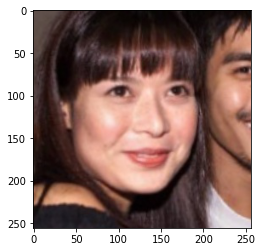

In [5]:
images_lr, images_hr = iter(train_loader).next()
image=images_hr[0]
print(image.size())
image_np=image.numpy()
print(image_np.max(),image_np.min())
image_np=np.transpose(image_np,(1,2,0))
plt.imshow(image_np)

torch.Size([3, 64, 64])
0.99607843 0.0


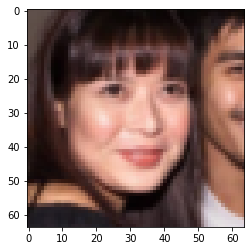

In [6]:
image=images_lr[0]
print(image.size())
image_np=image.numpy()
print(image_np.max(),image_np.min())
image_np=np.transpose(image_np,(1,2,0))
plt.imshow(image_np)

# initialize weights

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator
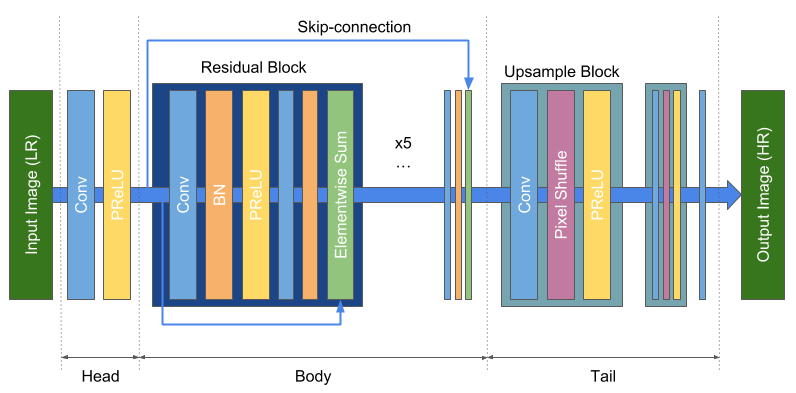

In [8]:
class Generator(nn.Module):
    def __init__(self,ngpu,image_size):
        super(Generator,self).__init__()
        self.ngpu = ngpu
        self.image_size=image_size
        
        self.pre_layer=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=9,stride=1,padding=4),
            nn.PReLU()
        )
        self.residual_layer=nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64)
        )
        self.middle_layer=nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64)
        )
        self.pixcelshuffer_layer=nn.Sequential(
            Pixcelshuffer(64,2),
            Pixcelshuffer(64,2),
            nn.Conv2d(64,3,kernel_size=9,stride=1,padding=4)
        )
    def forward(self,input_image):
        pre=self.pre_layer(input_image)
        res=self.residual_layer(pre)
        middle=self.middle_layer(res)
        middle=middle+pre
        output=self.pixcelshuffer_layer(middle)
        return output
    
    
class ResidualBlock(nn.Module):
    def __init__(self,input_channel):
        super(ResidualBlock,self).__init__()
        self.residualblock=nn.Sequential(
            nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(input_channel),
            nn.PReLU(),
            nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(input_channel)
        )
    def forward(self,x):
        residual=self.residualblock(x)
        return x+residual

class Pixcelshuffer(nn.Module):
    def __init__(self,input_channel,r): #r=upscale_factor
        super(Pixcelshuffer,self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(input_channel,256,kernel_size=3,stride=1,padding=1), 
            nn.PixelShuffle(r),
            nn.PReLU()
        )
    def forward(self,x):
        return self.layer(x)

In [9]:
ngpu = 1
image_size = 64
netG = Generator(ngpu,image_size).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu//2)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)
print("Create the generator")

Create the generator


In [10]:
test_input=torch.ones(1,3,64,64).to(device)
out=netG(test_input)
print(out.size())

torch.Size([1, 3, 256, 256])


# Discriminator
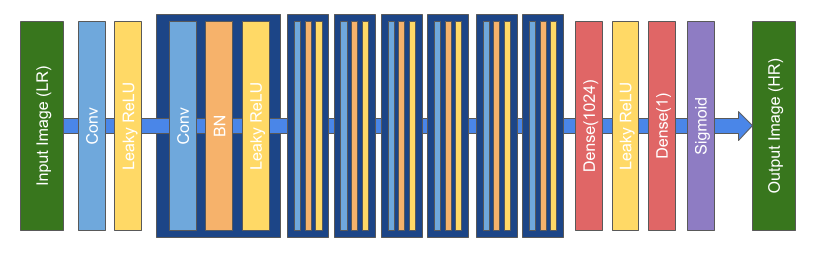

In [11]:
class Discriminator(nn.Module):
    def __init__(self,ngpu,patch_size):
        super(Discriminator,self).__init__()
        self.ngpu = ngpu
        self.conv_layers=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64,64,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128,128,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256,256,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(512,512,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2))#(512,16,16)
        
        self.dense_layer=nn.Sequential(
            nn.Linear(512*(patch_size//2** 4)**2,1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,1),
            nn.Sigmoid())
        
    def forward(self,input_image):
        batch_size=input_image.size()[0]
        
        conv=self.conv_layers(input_image)
        reshape=conv.view(batch_size,-1)
        output=self.dense_layer(reshape)
        
        return output

In [12]:
patch_size=256
# Create the Discriminator
netD = Discriminator(ngpu,patch_size).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu//2)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)
print("Create the Discriminator")

Create the Discriminator


In [13]:
test_input=torch.ones(1,3,256,256).to(device)
out=netD(test_input)
print(out.size())

torch.Size([1, 1])


# loss & optimizer

In [ ]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg16(pretrained=True)
        vgg_loss = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in vgg_loss.parameters():
            param.requires_grad = False
        self.vgg_loss = vgg_loss
        self.mse_loss = nn.MSELoss()
        self.cross_entropy = nn.BCELoss()

    def forward(self, fake_rate, SR, HR):
        # MSE Loss
        MSE_loss = self.mse_loss(SR, HR)
        # VGG Loss
        VGG_loss = self.mse_loss(self.vgg_loss(SR), self.vgg_loss(HR))
        # Adversarial Loss
        Adversarial_loss = self.cross_entropy(fake_rate,torch.ones(fake_rate.size(0)).cuda())
        return MSE_loss + 6e-3 * VGG_loss + 1e-3 * Adversarial_loss

In [ ]:
class DiscriminatorLoss(nn.Module):
    def __init__(self):
        super(DiscriminatorLoss, self).__init__()
        self.cross_entropy = nn.BCELoss()

    def forward(self, fake_rate, real_rate):
        # Fake_img Correct Rate
        Fake_img_CR = self.cross_entropy(fake_rate,torch.zeros(fake_rate.size(0)).cuda())
        # Real_img Correct Rate
        Real_img_CR = self.cross_entropy(real_rate,torch.ones(real_rate.size(0)).cuda())
        return Fake_img_CR + Real_img_CR

In [14]:
from torchvision.models.vgg import vgg19

class GeneratorLoss(nn.Module):
    def __init__(self, loss_type='vgg22', adv_coefficient=1e-3):
        super(GeneratorLoss, self).__init__()
        self.content_loss = VGGLoss(loss_type)
        self.mse_loss = nn.MSELoss()
        self.adv_coefficient = adv_coefficient

    def forward(self, d_out_fake, real_img, fake_img):
        mse_loss = self.mse_loss(real_img, fake_img)
        content_loss = self.content_loss(real_img, fake_img)
        adv_loss = torch.mean(-torch.log(d_out_fake + 1e-3))
        return mse_loss + 2e-6*content_loss + self.adv_coefficient*adv_loss


class VGGLoss(nn.Module):
    def __init__(self, loss_type):
        super(VGGLoss, self).__init__()
        vgg = vgg19(pretrained=True)
        if loss_type == 'vgg22':
            vgg_net = nn.Sequential(*list(vgg.features[:9]))
        elif loss_type == 'vgg54':
            vgg_net = nn.Sequential(*list(vgg.features[:36]))
        
        for param in vgg_net.parameters():
            param.requires_grad = False

        self.vgg_net = vgg_net.eval()
        self.mse_loss = nn.MSELoss()

        self.register_buffer('vgg_mean', torch.tensor([0.485, 0.456, 0.406], requires_grad=False))
        self.register_buffer('vgg_std', torch.tensor([0.229, 0.224, 0.225], requires_grad=False))

    def forward(self, real_img, fake_img):
        real_img = real_img.sub(self.vgg_mean[:, None, None]).div(self.vgg_std[:, None, None])
        fake_img = fake_img.sub(self.vgg_mean[:, None, None]).div(self.vgg_std[:, None, None])
        feature_real = self.vgg_net(real_img)
        feature_fake = self.vgg_net(fake_img)
        return self.mse_loss(feature_real, feature_fake)


class DiscriminatorLoss(nn.Module):
    def __init__(self):
        super(DiscriminatorLoss, self).__init__()
        self.bce_loss = nn.BCELoss()

    def forward(self, d_out_real, d_out_fake):
        loss_real = self.bce_loss(d_out_real, torch.ones_like(d_out_real))
        loss_fake = self.bce_loss(d_out_fake, torch.zeros_like(d_out_fake))
        return loss_real + loss_fake

In [15]:
mse_loss = nn.MSELoss().to(device)
criterionG = GeneratorLoss().to(device)
criterionD = DiscriminatorLoss().to(device)

In [16]:
G_optimizer = optim.Adam(netG.parameters(), lr=1e-4)
D_optimizer = optim.Adam(netD.parameters(), lr=1e-4)

# Training

In [17]:
num_epochs = 500
fixed_lr = iter(train_loader).next()[0].to(device)
G_losses=[]
D_losses=[]
fake_img_list=[]

for epoch in range(1, num_epochs + 1):
    netG.train(), netD.train()
    for iteration, (input_img, real_img) in enumerate(train_loader, 1):
        input_img = input_img.to(device)
        real_img = real_img.to(device)
        fake_img = netG(input_img)
        
        ############################
        # (1) Update D network: maximize D(x)-1-D(G(z))
        ###########################
        netD.zero_grad()
        d_out_real = netD(real_img)
        d_out_fake = netD(fake_img).detach()
        d_loss = criterionD(d_out_real, d_out_fake)
        d_loss.backward(retain_graph=True)
        D_optimizer.step()

        ############################
        # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
        ###########################
        netG.zero_grad()
        g_loss = criterionG(d_out_fake, real_img, fake_img)
        g_loss.backward()
        G_optimizer.step()
        
    ############################
    # Log progress
    ###########################
    if epoch%1==0:
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        netG.eval()
        with torch.no_grad():
            fake = netG(fixed_lr).detach().cpu()
        fake_grid = cv2.rotate(np.transpose(vutils.make_grid(fake, padding=2, normalize=True).numpy()),cv2.ROTATE_90_CLOCKWISE)
        fake_img_list.append(fake_grid)

        print('[%d/%d][%d/%d]\tLoss_D: %.6f\tLoss_G: %.6f'
          %(epoch, num_epochs, iteration, len(train_loader), d_loss.item(), g_loss.item()))
        plt.figure(figsize=(10,10))
        plt.imshow(fake_grid)
        plt.show()

KeyboardInterrupt: 

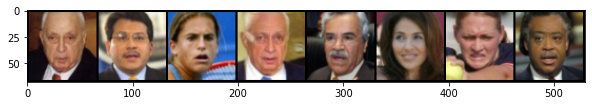

In [72]:
fake = fixed_lr.detach().cpu()
fake_grid = cv2.rotate(np.transpose(vutils.make_grid(fake, padding=2, normalize=True).numpy()),cv2.ROTATE_90_CLOCKWISE)
plt.figure(figsize=(10,10))
plt.imshow(fake_grid)